# 3D Tomography Experiments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pmcx
from utils import add_ball_to_array

### medium geometry

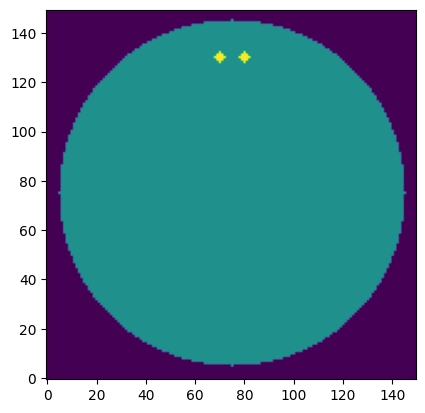

In [52]:
# number of voxels in each dimension
nx = 150
ny = 150
nz = 1 # 2d
r_head = 70 # head radius

# background
region = np.zeros((nz, ny, nx))

# head
region = add_ball_to_array(region, (0, ny // 2, nx//2), r_head, 1)

# add balls
depth = 10 # mm (note this is the depth to the center of the ball)
separation = 5 # mm
region = add_ball_to_array(region, (0, 130, nx//2 - np.floor(separation)), 2, 2)
region = add_ball_to_array(region, (0, 130, nx//2 + np.ceil(separation)), 2, 2)

plt.imshow(region[0])
plt.gca().invert_yaxis()
plt.show()

### sensor geometry

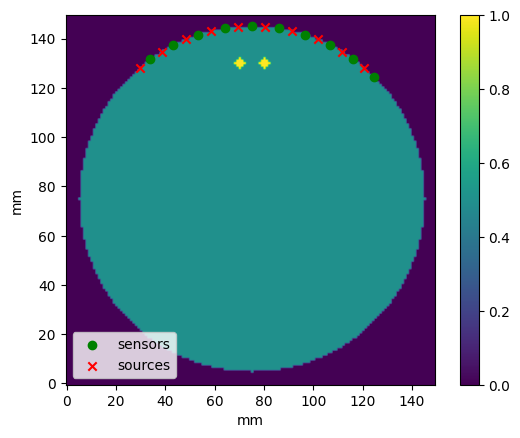

In [79]:
noptodes = 10 # number of optodes (this equates to roughly 1cm spacing)
sensor_positions = np.zeros((noptodes, 2))
source_positions = np.zeros((noptodes, 2))

# Create an array of i values
i_values = np.arange(noptodes)

# Calculate phi for q and m
phi_sensors = i_values / noptodes * np.pi / 2 + np.pi / 4
phi_sources = (i_values + 0.5) / noptodes * np.pi / 2 + np.pi / 4

# Calculate sensor and source positions
center_point = np.array([ny // 2, nx // 2])
sensor_positions  = r_head * np.vstack((np.sin(phi_sensors), np.cos(phi_sensors))).T + center_point
source_positions  = r_head * np.vstack((np.sin(phi_sources), np.cos(phi_sources))).T + center_point
source_directions = center_point - source_positions
source_directions = source_directions / np.linalg.norm(source_directions, axis=1)[:,None] # normalize

# add a column of zeros to cast as 3D
source_positions = np.hstack((np.zeros((noptodes, 1)), source_positions))
sensor_positions = np.hstack((np.zeros((noptodes, 1)), sensor_positions))
source_directions = np.hstack((np.zeros((noptodes, 1)), source_directions))

plt.figure()
plt.imshow(region[0,...])
plt.scatter(sensor_positions[:,-1], sensor_positions[:,-2], c='g', marker='o', label='sensors')
plt.scatter(source_positions[:,-1], source_positions[:,-2], c='r', marker='x', label='sources')
plt.gca().invert_yaxis()
plt.xlabel("mm"); plt.ylabel("mm")
plt.colorbar()
plt.legend()
plt.show()

In [80]:
def forward(volume, optical_properties, source_positions, source_directions, 
            detector_positions):
    """
    Implements the forward monte carlo solver.
    """

    config = {
        'nphoton': 1000000,
        'vol': volume,
        'tstart': 0,
        'tend': 1e-8,
        'tstep': 1e-8,
        'srcpos': source_positions,
        'srcdir': source_directions,
        'prop': optical_properties,
        'detpos': detector_positions,
        # 'replaydet':-1,
        'issavedet': 1,
        'issrcfrom0': 1,
        'issaveseed': 1,
        # 'unitinmm': 1.8,
        'maxdetphoton': 1000000000
    }

    result = pmcx.run(config)
    return result, config

def compute_jacobian(forward_result, config):
    
    config['seed']       = forward_result['seeds']  # one must define config['seed'] using the returned seeds
    config['detphotons'] = forward_result['detp']   # one must define config['detphotons'] using the returned detp data
    config['outputtype'] = 'jacobian'               # tell mcx to output absorption (μ_a) Jacobian

    result = pmcx.run(config)
    return result, config

In [81]:
source_index = 0

# info about region
percent_change = 1.05

g = 0.9                    # anisotropy factor
mua0   = 0.02               # background absorption [1/mm]
mus0   = 0.67/(1-g)               # background scattering [1/mm]
mua1 = mua0 * percent_change # absorption of perturbation [1/mm]
mus1 = mus0 * percent_change # scattering of perturbation [1/mm]
refind = 1.4                # refractive index

optical_properties = [
    [0,0,1,1],
    [mua0, mus0, g, refind],
    [mua1, mus1, g, refind]
    ]

forward(region, optical_properties, source_positions[source_index], source_directions[source_index], sensor_positions)

nphoton: 1e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+09
issrcfrom0: 1
srcpos: [0, 128.228, 120.461, 1]
srcdir: [0, -0.760406, -0.649448, 0]


ValueError: the 'detpos' field must have 4 columns (x,y,z,radius)

In [73]:
source_positions

array([[  0.        ,   0.        , 128.22841759, 120.46136338],
       [  0.        ,   0.        , 134.6848115 , 111.57489953],
       [  0.        ,   0.        , 139.67156728, 101.78784027],
       [  0.        ,   0.        , 143.06589443,  91.34117547],
       [  0.        ,   0.        , 144.78421336,  80.4921367 ],
       [  0.        ,   0.        , 144.78421336,  69.5078633 ],
       [  0.        ,   0.        , 143.06589443,  58.65882453],
       [  0.        ,   0.        , 139.67156728,  48.21215973],
       [  0.        ,   0.        , 134.6848115 ,  38.42510047],
       [  0.        ,   0.        , 128.22841759,  29.53863662]])

In [69]:
source_positions

array([[120.46136338, 128.22841759,   0.        ],
       [111.57489953, 134.6848115 ,   0.        ],
       [101.78784027, 139.67156728,   0.        ],
       [ 91.34117547, 143.06589443,   0.        ],
       [ 80.4921367 , 144.78421336,   0.        ],
       [ 69.5078633 , 144.78421336,   0.        ],
       [ 58.65882453, 143.06589443,   0.        ],
       [ 48.21215973, 139.67156728,   0.        ],
       [ 38.42510047, 134.6848115 ,   0.        ],
       [ 29.53863662, 128.22841759,   0.        ]])

## Junk

In [ ]:
pmcx.gpuinfo()

In [29]:
# prop: (µa, µs, g, n)

prop = np.array([
    [0,0,1,1], # air
    [0.0200,  9.0000,  0.8900,  1.3700]]) # gray matter
cfg = {
       'nphoton': 1000000,
       'vol':np.ones([1,60,60],dtype='uint8'),
       'tstart':0,
       'tend':5e-9,
       'tstep':5e-9,
       'srcpos': [0,30,0],
       'srcdir':[0,0,1],
       'prop': prop,
       # 'detpos': [[0,30,30, 2],[0,30,30,2], [0,30,0,2]],
       'issavedet': 0,
       'issrcfrom0': 1
       }
res = pmcx.mcxlab(cfg)


nphoton: 1e+06
tstart: 0
tstep: 5e-09
tend: 5e-09
issrcfrom0: 1
srcpos: [0, 30, 0, 1]
srcdir: [0, 0, 1, 0]
issavedet: 0
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #


In [18]:
res['flux'].shape

(1, 60, 60, 1)

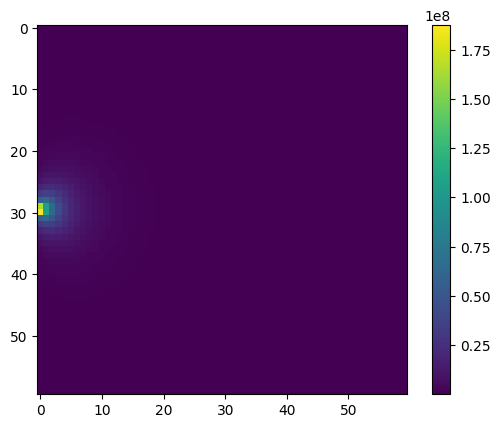

In [30]:
plt.imshow((res['flux'][0,:, :]))
plt.colorbar()
plt.show()

In [16]:
plt.hist(res['detp']['ppath'][:,0], bins=100, range=[0,200]);

KeyError: 'detp'

In [ ]:
from pmcx import dettime
arrival_times = dettime(res['detp'], prop=prop)

In [89]:
arrival_times.shape

(1, 48155)

In [ ]:
plt.hist(arrival_times[0,:], bins=100, range=[0, 0.5e-9])
plt.show()

In [ ]:
import jdata as jd

In [ ]:
shape=[]
shape.append({'Grid':{'Tag':1, 'Size':[40,60,30]}})
shape.append({'Sphere':{'Tag':2, 'O':[20,30,10], 'R':10}})

cfg['shapes']=jd.show({'Shapes':shape}, {'string':True})

In [ ]:
hist, bins = np.histogram(res['detp']['data'][0])
print("Histogram values:", hist)
print("Bins:", bins)

In [ ]:
res['detp']['detid'].shape

In [ ]:
res['detp']['data'].shape

In [ ]:
np.sum(res['detp']['data'][0] - res['detp']['detid'])

In [ ]:
plt.imshow(np.log10(res['flux'][30,:, :]))
plt.show()

In [ ]:
plt.imshow(np.log10(res['flux'][30,:, :]))
plt.show()